In [157]:
import os
import docvision as dv
import docgenpipe as dg
import docdataset as dd

In [158]:
cd ..

/Users/asukh/Work/VSCode/Python/ucu-mt


/opt/miniconda3/envs/python3.10-mt-vlm/lib/python3.10/site-packages/IPython/core/magics/osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [2]:
cd /root/ucu-mt

[Errno 2] No such file or directory: '/root/ucu-mt'
/Users/asukh/Work/VSCode/Python/ucu-mt/src


/opt/miniconda3/envs/python3.10-mt-vlm/lib/python3.10/site-packages/IPython/core/magics/osm.py:393: UserWarning: This is now an optional IPython functionality, using bookmarks requires you to install the `pickleshare` library.
  bkms = self.shell.db.get('bookmarks', {})


In [159]:
dataset = dd.download_dataset()['train']

In [160]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
from collections import defaultdict

def analyze_grounding_word_counts_from_dataset(dataset: list[dict], count_mode: str = "word"):
    """
    Aggregates and returns total word or character counts from all 'text' grounding entries per document.

    Args:
        dataset (list[dict]): The input dataset.
        count_mode (str): "word" to count words, "char" to count characters (default: "word").

    Returns:
        pd.DataFrame: Aggregated count statistics per document.
    """
    assert count_mode in ["word", "char"], "count_mode must be 'word' or 'char'"

    doc_texts = defaultdict(str)
    meta = {}


    for doc_id, row in enumerate(dataset):
        category = row.get("category", "unknown")
        style = row.get("style", "unknown")
        meta[doc_id] = {"category": category, "style": style}
        for g in row.get("grounding", []):
            if g.get("type") == "text":
                doc_texts[doc_id] += " " + g.get("content", "")


    records = []
    for doc_id, full_text in doc_texts.items():
        if count_mode == "word":
            count = len(re.findall(r'\w+', full_text, re.UNICODE))
        else: 
            count = len(full_text)

        records.append({
            "doc_id": doc_id,
            "category": meta[doc_id]["category"],
            "style": meta[doc_id]["style"],
            "count": count
        })

    df = pd.DataFrame(records)

    agg_df = df.groupby(['doc_id', 'category', 'style'])['count'].agg(['min', 'max', 'mean']).reset_index()

    return agg_df


In [161]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

def plot_combined_word_counts(agg_df, count_mode):
    """
    Creates a single boxplot for word count distribution:
    - Overall word count per document
    - Per style (print, hand, scan)
    """
    sns.set_theme(style="white")

    plt.figure(figsize=(10, 6))

    overall_df = agg_df.copy()
    overall_df["style"] = "overall"
    combined_df = pd.concat([agg_df, overall_df], ignore_index=True)

    palette = sns.blend_palette(["#a5d6a7", "#ce93d8"], n_colors=4)

    sns.boxplot(data=combined_df, x="style", y="mean", palette=palette)

    plt.xlabel("")
    plt.ylabel(f"{count_mode} Count", fontsize=12)
    plt.xticks(fontsize=11)
    plt.yticks(fontsize=11)

    plt.grid(False)
    sns.despine(top=True, right=True)

    plt.show()

/var/folders/yr/4p_vsm354x598ht21719ydj80000gq/T/ipykernel_32208/2234650098.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=combined_df, x="style", y="mean", palette=palette)


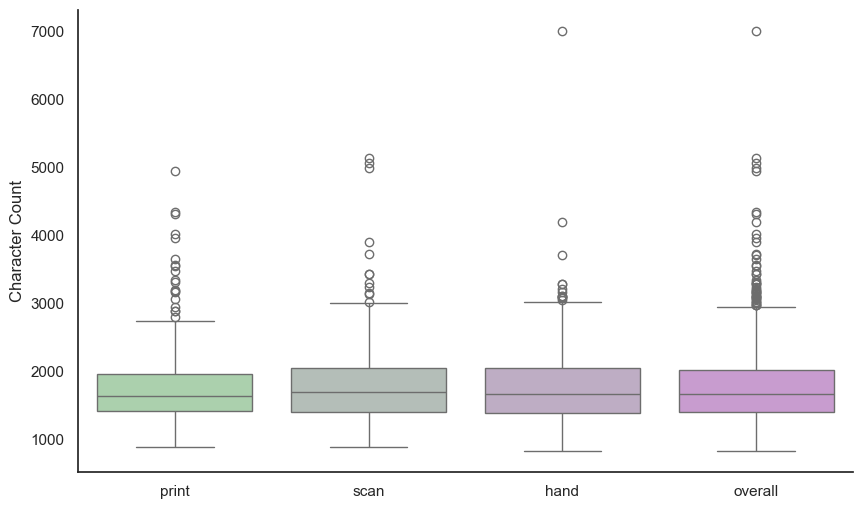

In [162]:
stats_df = analyze_grounding_word_counts_from_dataset(dataset, count_mode="char")
plot_combined_word_counts(stats_df, count_mode="Character")

In [164]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
from collections import defaultdict


def extract_word_counts(dataset: list[dict], count_mode: str = "word"):
    """
    Extracts word or character counts from all 'text' grounding entries per document.

    Args:
        dataset (list[dict]): Input dataset with grounding entries.
        count_mode (str): "word" to count words, "char" to count characters.

    Returns:
        pd.DataFrame: Document-level rows with count, category, and style.
    """
    assert count_mode in ["word", "char"], "count_mode must be 'word' or 'char'"
    
    records = []

    for doc_id, row in enumerate(dataset):
        category = row.get("category", "unknown")
        style = row.get("style", "unknown")

        full_text = " ".join(
            g.get("content", "") for g in row.get("grounding", []) if g.get("type") == "text"
        )

        if count_mode == "word":
            count = len(re.findall(r'\w+', full_text, re.UNICODE))
        else:
            count = len(full_text)

        records.append({
            "doc_id": doc_id,
            "category": category,
            "style": style,
            "count": count
        })

    return pd.DataFrame(records)


def plot_count_histograms(df):
    """
    Creates a 2x2 grid of histograms for word/char count distribution using Seaborn:
    - (Top-left) Overall count per document
    - (Top-right) Histogram for "print"
    - (Bottom-left) Histogram for "hand"
    - (Bottom-right) Histogram for "scan"
    """
    sns.set_theme(style="white")

    fig, axes = plt.subplots(2, 2, figsize=(12, 10))

    palette = sns.blend_palette(["#a5d6a7", "#ce93d8"], n_colors=4)

    styles = ["overall", "print", "hand", "scan"]
    titles = {
        "overall": "Overall",
        "print": "Print",
        "hand": "Hand",
        "scan": "Scan"
    }

    style_data = {
        "overall": df,
        "print": df[df["style"] == "print"],
        "hand": df[df["style"] == "hand"],
        "scan": df[df["style"] == "scan"]
    }

    for i, style in enumerate(styles):
        row, col = divmod(i, 2)
        ax = axes[row, col]
        subset = style_data[style]

        if not subset.empty:
            sns.histplot(subset["count"], bins=20, kde=True, color=palette[i], alpha=0.7, ax=ax)
            ax.set_title(titles[style])
            ax.set_xlabel("Count" if row == 1 else "")
            ax.set_ylabel("Frequency" if col == 0 else "")
            sns.despine(ax=ax, top=True, right=True)
        else:
            ax.set_visible(False)

    plt.tight_layout()
    plt.show()


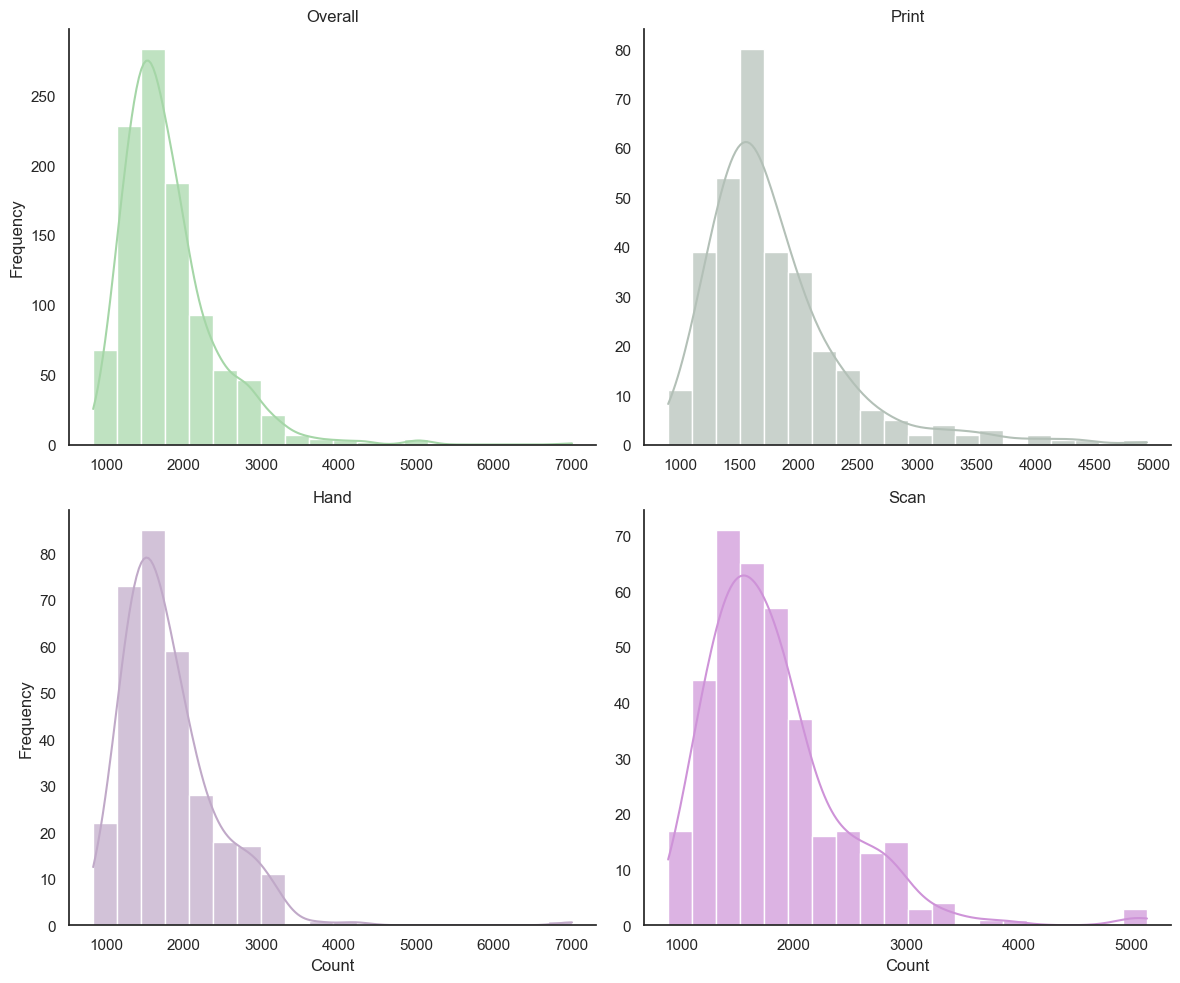

In [165]:

stats_df = extract_word_counts(dataset, count_mode="char") 
plot_count_histograms(stats_df)


In [ ]:
example = dataset.filter(lambda x: x['id'] == '0ae2e013a6024815b61a7b7692f34cf8')
example

Dataset({
    features: ['image', 'lang', 'category', 'title', 'style', 'template', 'grounding', 'id'],
    num_rows: 1
})

In [ ]:
def extract_image_dimensions(dataset: list[dict]) -> pd.DataFrame:
    """
    Extracts image width and height for each document.

    Returns:
        pd.DataFrame: Document-level rows with width, height, category, and style.
    """
    records = []

    for doc_id, row in enumerate(dataset):
        category = row.get("category", "unknown")
        style = row.get("style", "unknown")
        image = row.get("image", {})

        width, height = image.size

        if height > 1200:
            continue

        if width is not None and height is not None:
            records.append({
                "doc_id": doc_id,
                "category": category,
                "style": style,
                "width": width,
                "height": height
            })

    return pd.DataFrame(records)

def plot_dimension_histograms(df):
    """
    Plots histograms for overall image width and height (no style breakdown).
    """
    sns.set_theme(style="white")
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))

    sns.histplot(df["width"], bins=20, kde=True, color="#64b5f6", alpha=0.7, ax=axes[0])
    axes[0].set_title("Image Width Distribution")
    axes[0].set_xlabel("Width (px)")
    axes[0].set_ylabel("Frequency")
    sns.despine(ax=axes[0])

    sns.histplot(df["height"], bins=20, kde=True, color="#81c784", alpha=0.7, ax=axes[1])
    axes[1].set_title("Image Height Distribution")
    axes[1].set_xlabel("Height (px)")
    axes[1].set_ylabel("Frequency")
    sns.despine(ax=axes[1])

    plt.tight_layout()
    plt.show()



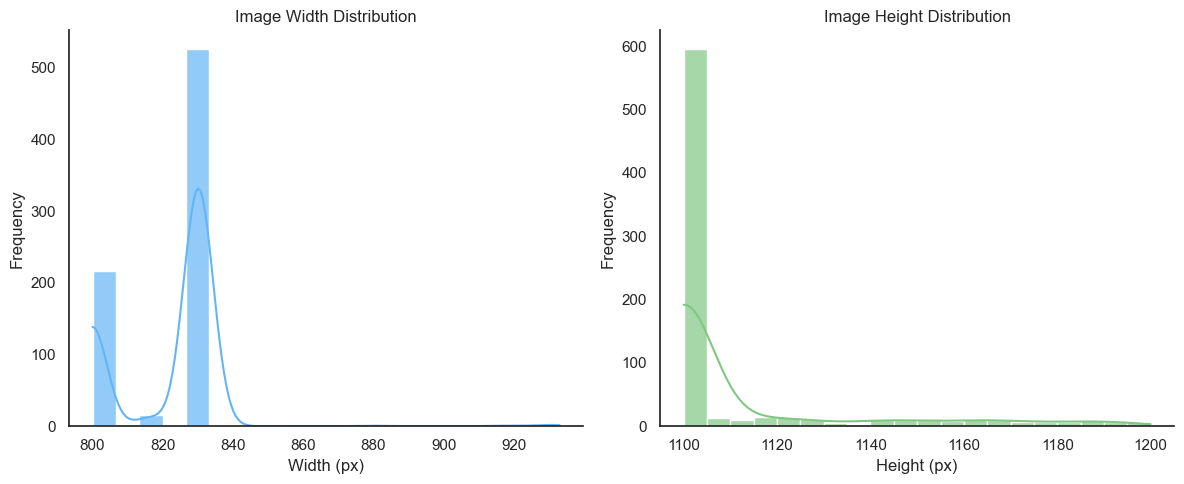

In [178]:
dimension_df = extract_image_dimensions(dataset)
plot_dimension_histograms(dimension_df)


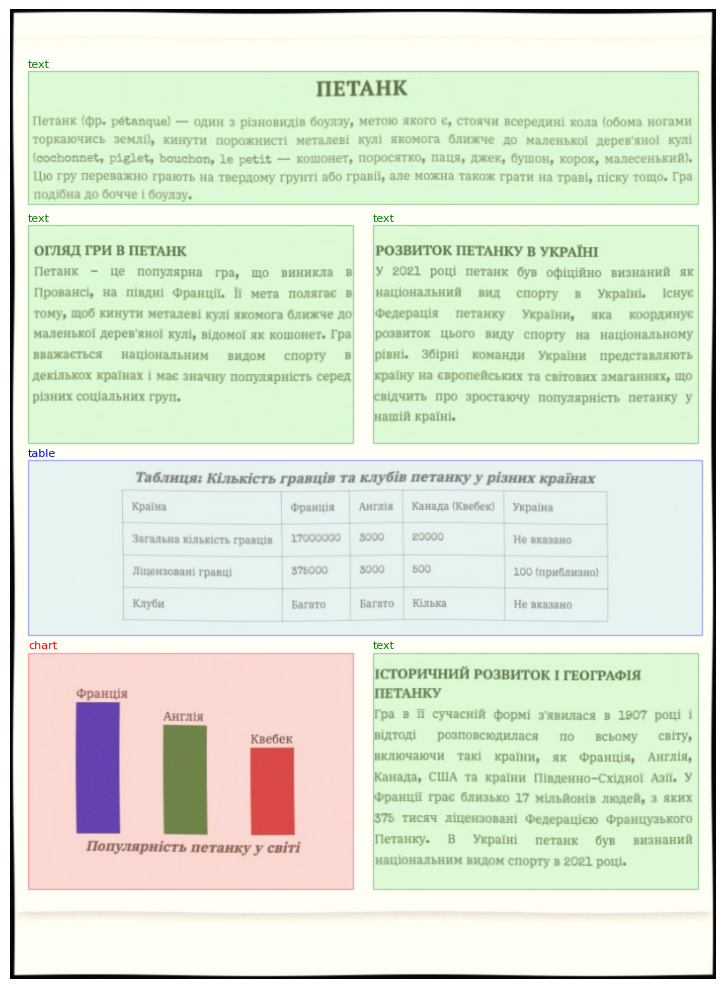

In [9]:
dv.visualize_grounding(example[0].get("image"), example[0]["grounding"])

In [286]:
import matplotlib.pyplot as plt
import numpy as np

def plot_radar_chart(
    data_dict,
    labels,
    origin=40,
    title=None,
    point_label_fontsize=12,
    axis_label_fontsize=12,
    legend_fontsize=12
):
    """
    Plot a radar chart showing only the smallest and largest values per metric,
    excluding values rendered at or below origin. Values below origin are clamped to origin for display.

    Args:
        data_dict (dict): Dictionary of {model_name: [metric scores]}.
        labels (list): Metric names (length should match values).
        origin (float): The minimum value baseline; values <= origin are not labeled.
        title (str): Title of the chart.
        point_label_fontsize (int): Font size for min/max value labels.
        axis_label_fontsize (int): Font size for axis labels (metrics).
        legend_fontsize (int): Font size for legend text.
    """
    def hide_outermost_gridline(ax, max_radius):
        for line in ax.yaxis.get_gridlines():
            path = line.get_path().vertices
            if len(path) > 0:
                radius = np.max(np.sqrt(path[:, 0]**2 + path[:, 1]**2))
                if np.isclose(radius, max_radius, atol=0.1):
                    line.set_visible(False)

    num_labels = len(labels)
    angles = np.linspace(0, 2 * np.pi, num_labels, endpoint=False).tolist()
    angles += angles[:1]

    model_names = list(data_dict.keys())
    original_values = np.array([data_dict[model] for model in model_names])
    clamped_values = np.where(original_values < origin, origin, original_values)

    data_clamped_closed = {
        model: list(clamped_values[i]) + [clamped_values[i][0]]
        for i, model in enumerate(model_names)
    }

    fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True))

    for model, values in data_clamped_closed.items():
        ax.plot(angles, values, label=model)
        ax.fill(angles, values, alpha=0.1)

    for i in range(num_labels):
        column = clamped_values[:, i]
        valid_mask = column > origin
        if not np.any(valid_mask):
            continue

        valid_values = column[valid_mask]
        valid_models = np.array(model_names)[valid_mask]

        min_val = np.min(valid_values)
        max_val = np.max(valid_values)
        angle = angles[i]

        for model in valid_models[valid_values == min_val]:
            ax.text(angle, min_val - 1.1, f"{min_val:.1f}",
                    ha='center', va='top', fontsize=point_label_fontsize, color="#111111",
                    transform=ax.transData)

        for model in valid_models[valid_values == max_val]:
            ax.text(angle, max_val + 1.1, f"{max_val:.1f}",
                    ha='center', va='bottom', fontsize=point_label_fontsize, color="#111111",
                    transform=ax.transData)

    ax.set_thetagrids(np.degrees(angles[:-1]), labels, fontsize=axis_label_fontsize)
    for label in ax.get_xticklabels():
        label.set_horizontalalignment('center')
        label.set_verticalalignment('center')
        label.set_position((label.get_position()[0], -0.15))

    ax.set_ylim(origin, 100)
    ax.spines['polar'].set_edgecolor('none')
    ax.set_yticklabels([])

    # Hide outermost gridline
    hide_outermost_gridline(ax, max_radius=100)

    if title is not None:
        plt.title(title, fontsize=12, pad=10, fontweight='semibold', color="#111111")

    plt.legend(loc='lower right', bbox_to_anchor=(1.3, 1), frameon=False, fontsize=legend_fontsize)
    plt.tight_layout()
    plt.show()



### Open-source vs Tesseract

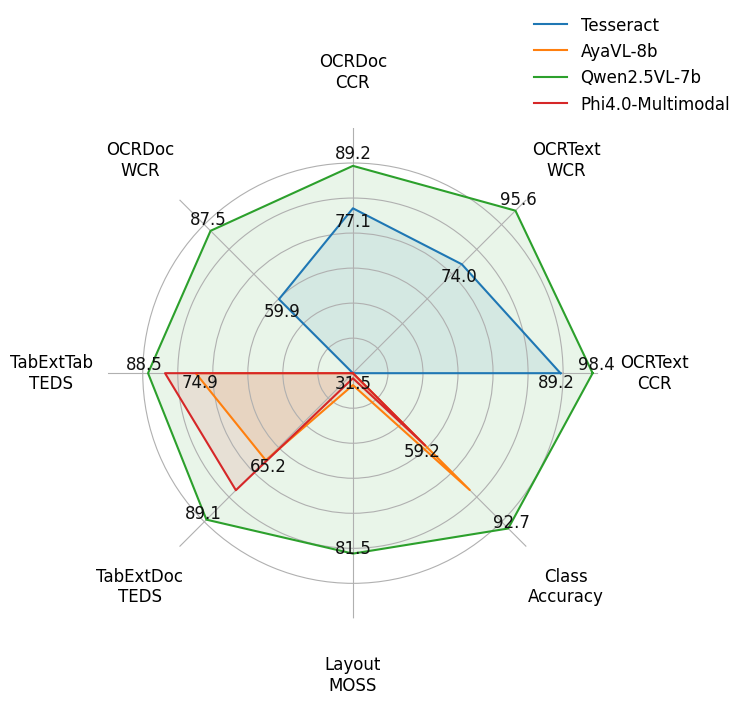

In [ ]:
labels = ['OCRText\nCCR', 'OCRText\nWCR', 'OCRDoc\nCCR', 'OCRDoc\nWCR',
          'TabExtTab\nTEDS', 'TabExtDoc\nTEDS', 'DLA\nMOSS', 'Class\nAccuracy']
# overall data
data_dict = {
    'Tesseract': [89.25, 73.97, 77.07, 59.87, 0, 0, 0, 0],
    'AyaVL-8b': [0, 0, 0, 0, 74.87, 65.17, 33.41, 77.18],
    'Qwen2.5VL-7b': [98.44, 95.62, 89.19, 87.48, 88.49, 89.14, 81.51, 92.70],
    'Phi4.0-Multimodal': [6.16, 0, 28.96, 6.19, 83.64, 77.26, 31.46, 59.19]
}
plot_radar_chart(data_dict, labels, origin=30)

### Top-1 open-source vs proprietary

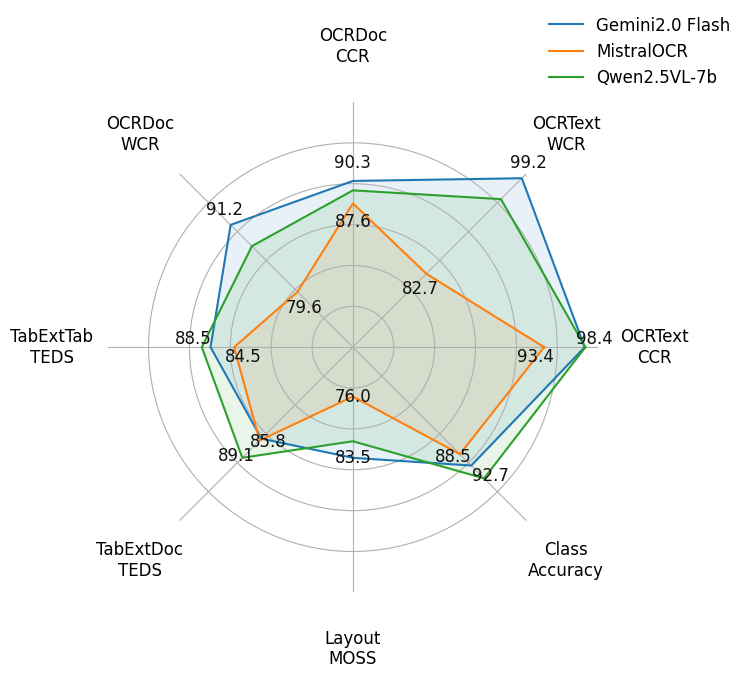

In [ ]:
labels = ['OCRText\nCCR', 'OCRText\nWCR', 'OCRDoc\nCCR', 'OCRDoc\nWCR',
          'TabExtTab\nTEDS', 'TabExtDoc\nTEDS', 'DLA\nMOSS', 'Class\nAccuracy']

data_dict = {
    'Gemini2.0 Flash': [98.36, 99.23, 90.34, 91.16, 87.42, 85.83, 83.54, 90.48],
    'MistralOCR': [93.40, 82.71, 87.59, 79.58, 84.54, 86.15, 76.04, 88.51],
    'Qwen2.5VL-7b': [98.44, 95.62, 89.19, 87.48, 88.49, 89.14, 81.51, 92.70],
}
plot_radar_chart(data_dict, labels, origin=70)

### Pretrained vs Fine-tuning

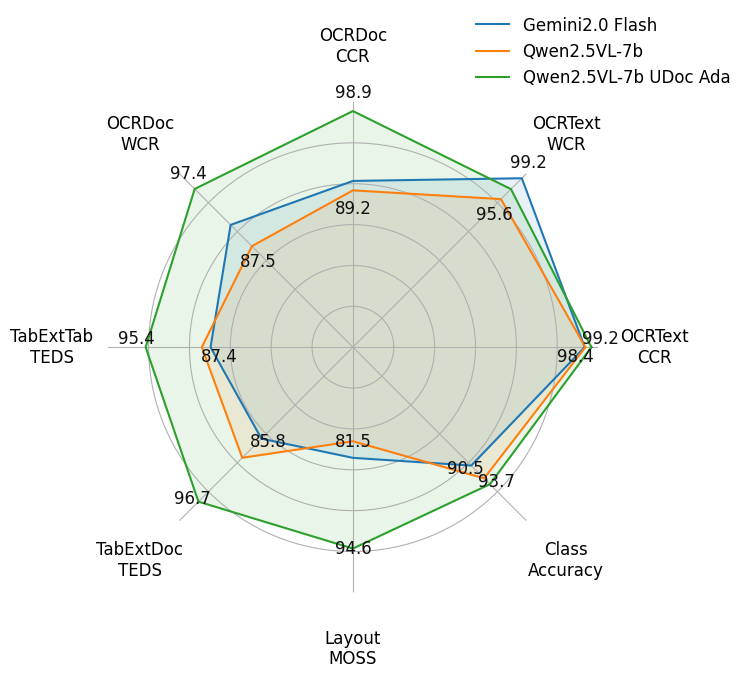

In [ ]:
labels = ['OCRText\nCCR', 'OCRText\nWCR', 'OCRDoc\nCCR', 'OCRDoc\nWCR',
          'TabExtTab\nTEDS', 'TabExtDoc\nTEDS', 'DLA\nMOSS', 'Class\nAccuracy']

data_dict = {
    'Gemini2.0 Flash': [98.36, 99.23, 90.34, 91.16, 87.42, 85.83, 83.54, 90.48],
    'Qwen2.5VL-7b': [98.44, 95.62, 89.19, 87.48, 88.49, 89.14, 81.51, 92.70],
    'Qwen2.5VL-7b UDoc Ada': [99.18, 97.35, 98.89, 97.38, 95.36, 96.73, 94.64, 93.71],
}
plot_radar_chart(data_dict, labels, origin=70)

### By Style

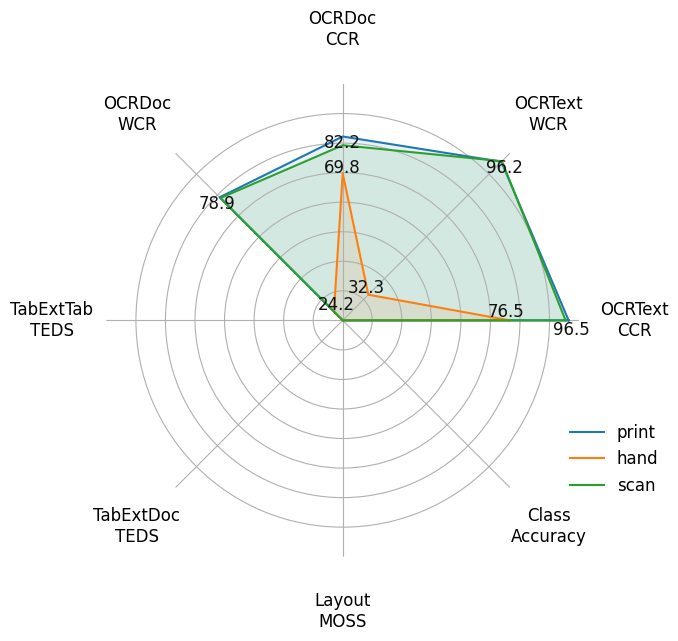

In [227]:
data_dict_tesseract = {
    'print': [96.46, 95.95, 82.24, 78.92, 0, 0, 0, 0],
    'hand': [76.47, 32.28, 69.75, 24.21, 0, 0, 0, 0],
    'scan': [95.44, 96.20, 79.28, 78.56, 0, 0, 0, 0],
}
plot_radar_chart(data_dict_tesseract, labels, origin=20, )

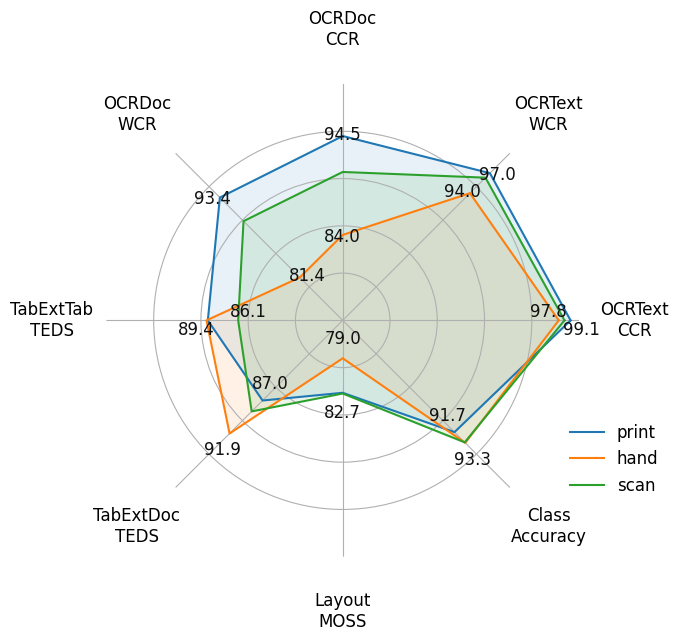

In [226]:
data_dict_qwen2_5vl_7b = {
    'print': [99.10, 97.02, 94.50, 93.38, 89.27, 86.99, 82.66, 91.72],
    'hand': [97.85, 94.03, 84.04, 81.42, 89.41, 91.93, 79.01, 93.33],
    'scan': [98.46, 96.35, 90.70, 89.84, 86.06, 88.62, 82.74, 93.25],
}
plot_radar_chart(data_dict_qwen2_5vl_7b, labels, origin=75)

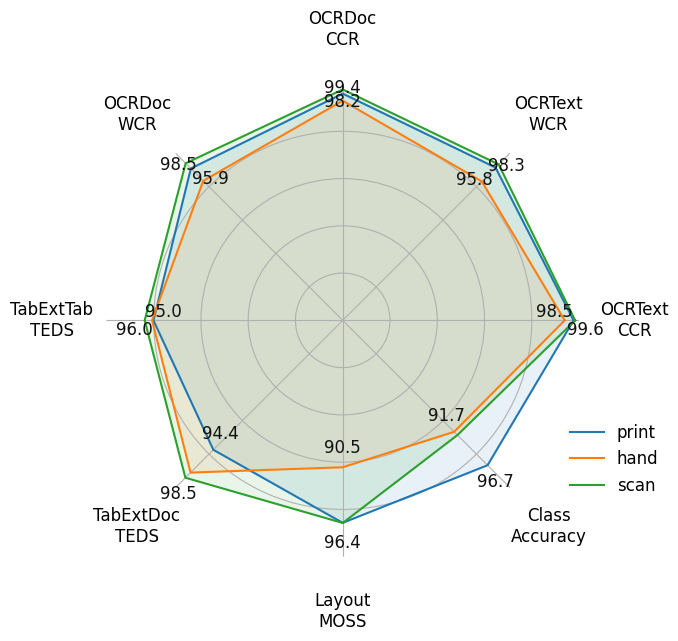

In [228]:
data_dict_qwen2_5vl_7b_ada = {
    'print': [99.42, 97.86, 98.99, 97.72, 95.02, 94.36, 96.42, 96.67],
    'hand': [98.48, 95.80, 98.24, 95.87, 95.17, 97.77, 90.54, 91.67],
    'scan': [99.59, 98.33, 99.43, 98.50, 95.95, 98.54, 96.43, 92.16],
}
plot_radar_chart(data_dict_qwen2_5vl_7b_ada, labels, origin=75)

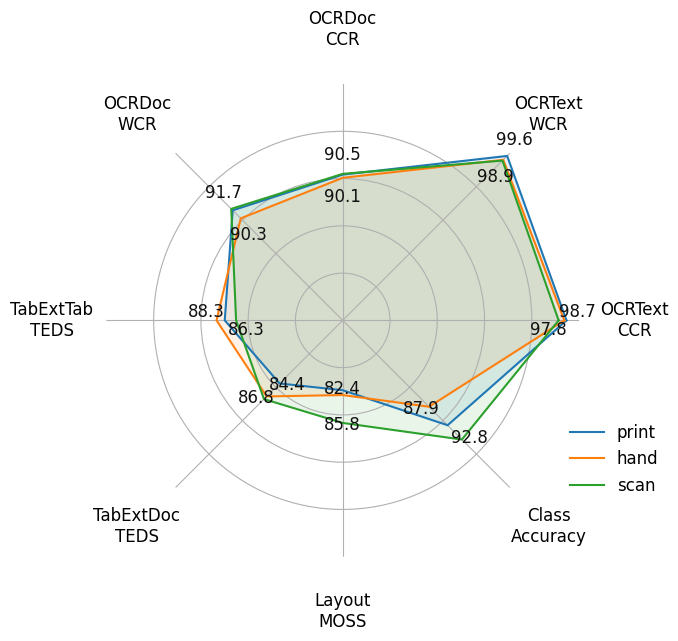

In [232]:
data_dict_gemini = {
    'print': [98.67, 99.60, 90.42, 91.46, 87.48, 84.44, 82.39, 90.69],
    'hand': [98.44, 99.02, 90.08, 90.26, 88.35, 86.38, 82.90, 87.92],
    'scan': [97.84, 98.90, 90.50, 91.68, 86.28, 86.78, 85.85, 92.83],
}
plot_radar_chart(data_dict_gemini, labels, origin=75)